Iñigo Martin Melero

## Participante 7

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_7_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0      5.0     10
1           50      5.0      5.0     10
2          100      5.0      5.0     10
3          150      5.0      5.0     10
4          200      5.0      5.0     10
...        ...      ...      ...    ...
49027  2451350      5.0      5.0     12
49028  2451400      5.0      5.0     12
49029  2451450      5.0      5.0     12
49030  2451500      5.0      5.0     12
49031  2451550      5.0      5.0     12

[49032 rows x 4 columns]


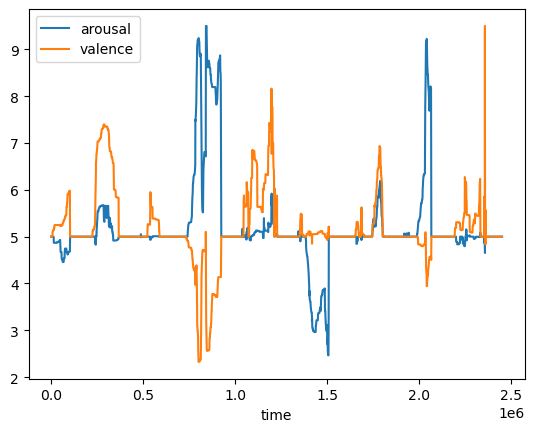

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_7_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  0.285  35.372  35.417  43.030  30.290     9.793     8.932   
1              1  0.229  35.488  35.397  43.010  30.290     9.793     8.850   
2              2  0.173  35.605  35.377  42.991  30.290     9.793     8.767   
3              3  0.114  35.711  35.334  43.000  30.287     9.793     8.848   
4              4  0.055  35.396  35.334  43.048  30.301     9.915     8.971   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  0.935  34.258  20.525  41.858  31.311   173.303     7.534   
2451580  2451580  0.922  34.029  20.541  41.839  31.314   184.427     7.534   
2451581  2451581  0.922  34.190  20.553  41.829  31.311   194.743     7.494   
2451582  2451582  0.938  34.326  20.529  41.858  31.314   207.572     7.494   
2451583  2451583  0.941  34.423  20.432  41.887  31.324   219.126     7.453   

         emg_trap  video  
0          11.602     10

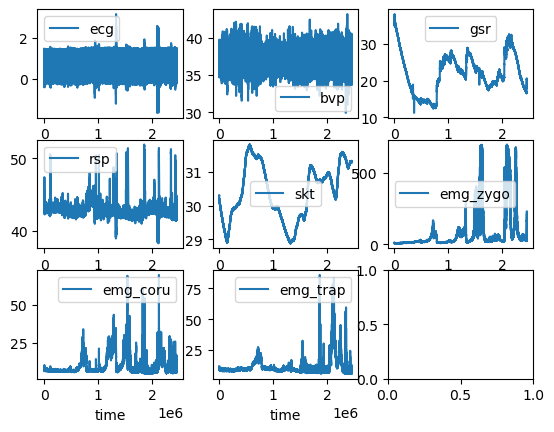

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

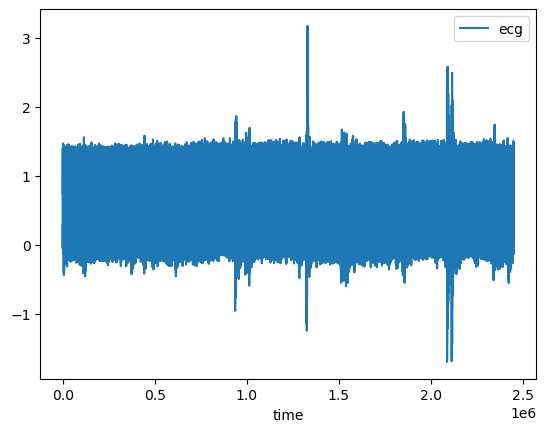

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

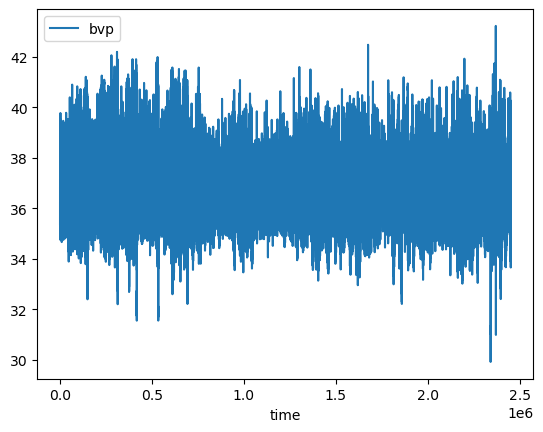

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

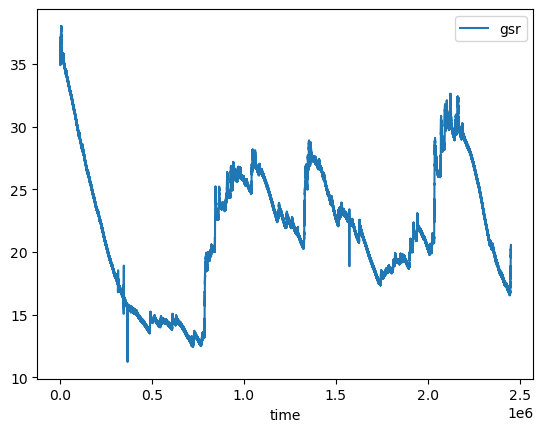

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

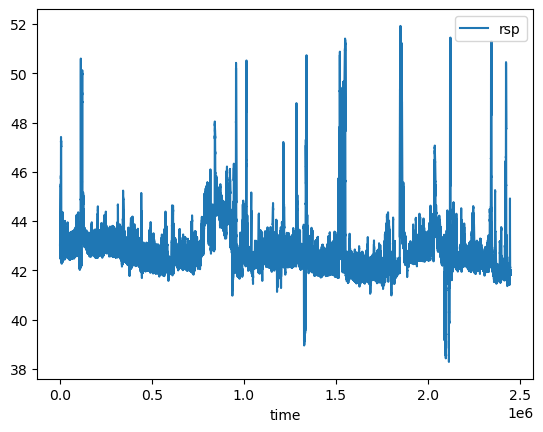

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

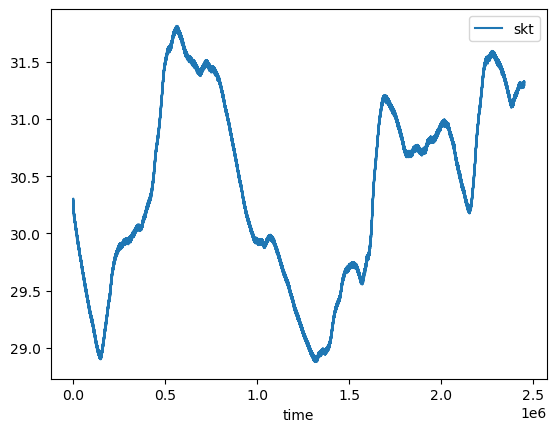

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

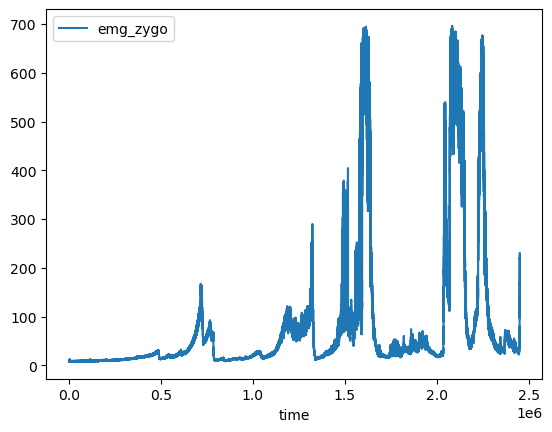

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

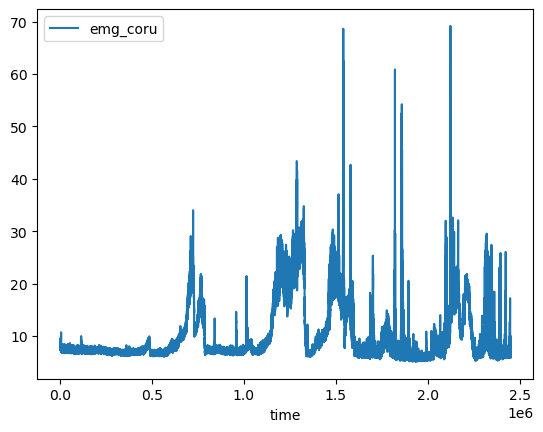

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

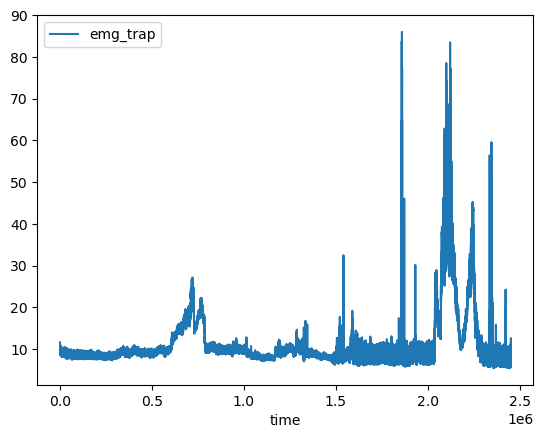

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

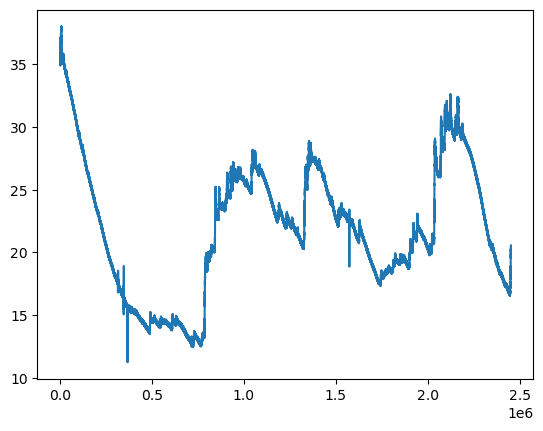

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

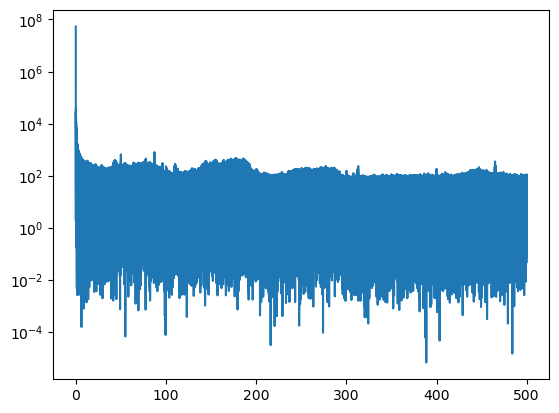

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

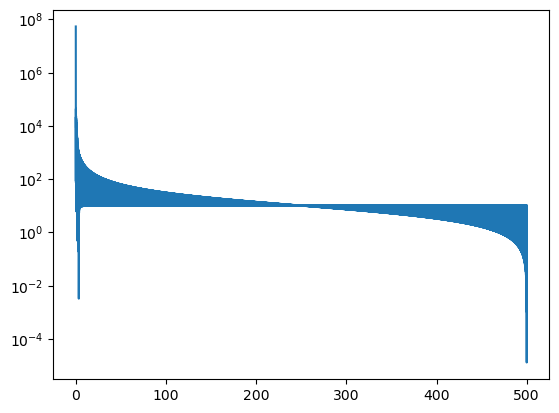

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

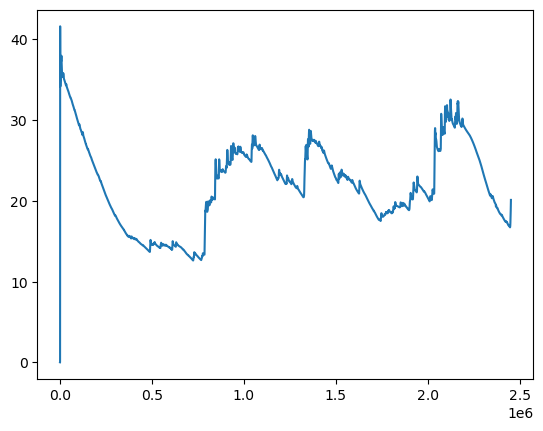

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  20.104
2451580  20.105
2451581  20.106
2451582  20.107
2451583  20.108

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

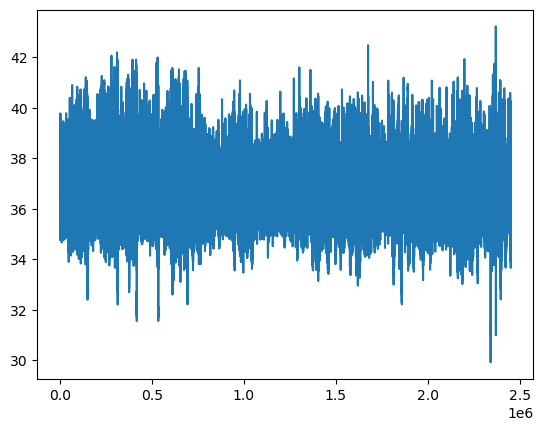

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

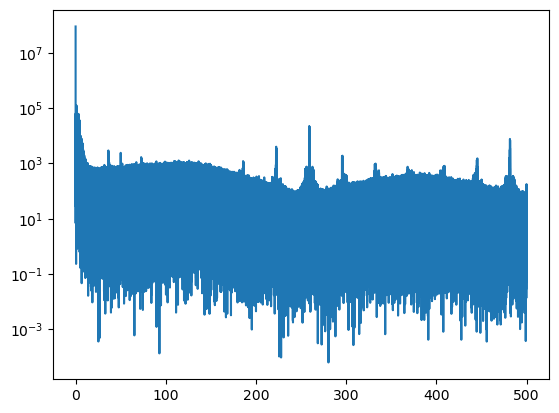

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

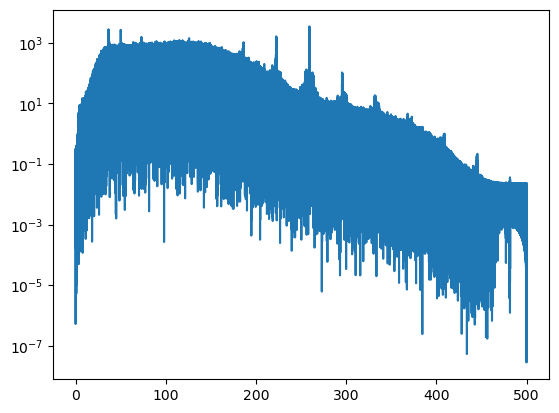

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

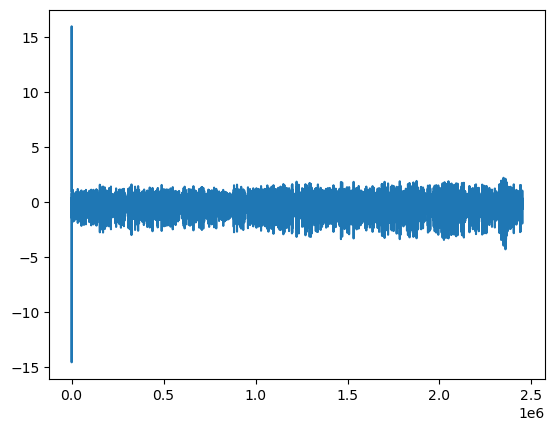

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        37.983
1        42.486
2        49.922
3        53.015
4        46.025
...         ...
2451579  37.001
2451580  37.020
2451581  37.092
2451582  37.105
2451583  37.066

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

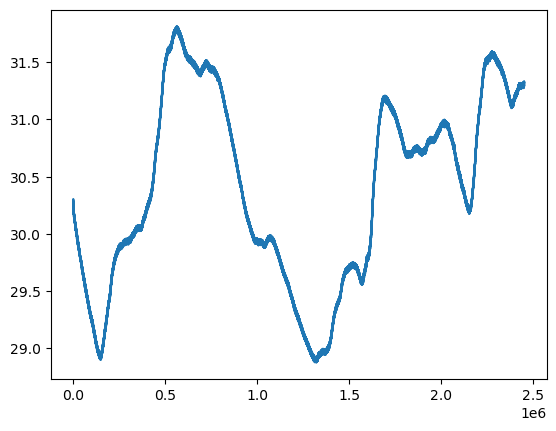

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

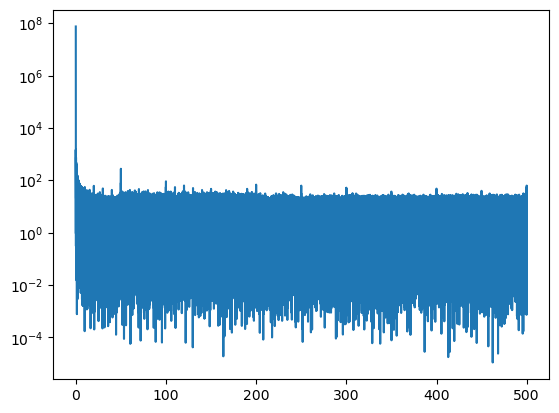

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

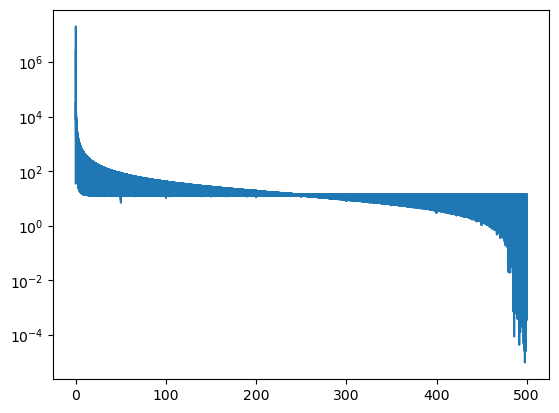

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

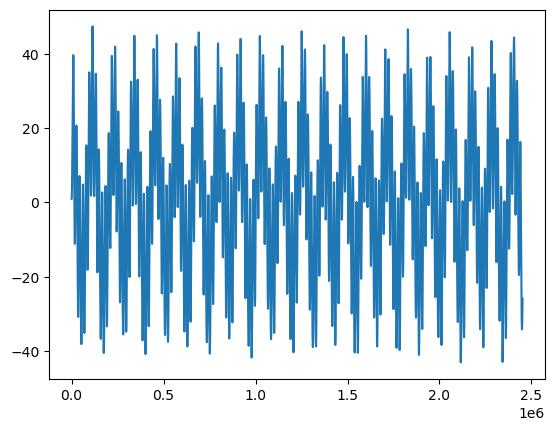

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.971
1        40.971
2        40.971
3        40.971
4        40.971
...         ...
2451579  14.001
2451580  14.006
2451581  14.011
2451582  14.016
2451583  14.021

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  0.285  43.030     9.793     8.932    11.602     10
1              1  0.229  43.010     9.793     8.850    11.438     10
2              2  0.173  42.991     9.793     8.767    11.273     10
3              3  0.114  43.000     9.793     8.848    11.394     10
4              4  0.055  43.048     9.915     8.971    11.436     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  0.935  41.858   173.303     7.534    10.696     12
2451580  2451580  0.922  41.839   184.427     7.534    10.697     12
2451581  2451581  0.922  41.829   194.743     7.494    10.778     12
2451582  2451582  0.938  41.858   207.572     7.494    10.820     12
2451583  2451583  0.941  41.887   219.126     7.453    10.861     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  0.285  43.030     9.793     8.932    11.602     10  37.983   
1              1  0.229  43.010     9.793     8.850    11.438     10  42.486   
2              2  0.173  42.991     9.793     8.767    11.273     10  49.922   
3              3  0.114  43.000     9.793     8.848    11.394     10  53.015   
4              4  0.055  43.048     9.915     8.971    11.436     10  46.025   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  0.935  41.858   173.303     7.534    10.696     12  37.001   
2451580  2451580  0.922  41.839   184.427     7.534    10.697     12  37.020   
2451581  2451581  0.922  41.829   194.743     7.494    10.778     12  37.092   
2451582  2451582  0.938  41.858   207.572     7.494    10.820     12  37.105   
2451583  2451583  0.941  41.887   219.126     7.453    10.861     12  37.066   

            gsr     skt  
0         0.000  40.971  
1         0.000  40.971  
2         0.000  40.971  
3         0.000  40.971  
4         0.000  40.971  
...         ...     ...  
2451579  20.104  14.001  
2451580  20.105  14.006  
2451581  20.106  14.011  
2451582  20.107  14.016  
2451583  20.108  14.021  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.575630  0.649159  0.558243  0.782542  0.304373  0.001783   
221502    221502  0.577206  0.645794  0.558243  0.782473  0.304373  0.001841   
221503    221503  0.577206  0.646916  0.558243  0.782392  0.304373  0.001780   
221504    221504  0.585609  0.648411  0.558243  0.782311  0.305659  0.001841   
221505    221505  0.582458  0.643364  0.558243  0.782242  0.307088  0.002024   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.563550  0.640561  0.481289  0.354661  0.137039  0.038081   
2331580  2331580  0.558298  0.650841  0.481289  0.354742  0.136896  0.037655   
2331581  2331581  0.570378  0.673084  0.481289  0.354822  0.135610  0.036982   
2331582  2331582  0.568803  0.681121  0.481289  0.354903  0.135610  0.036245   
2331583  2331583  0.560399  0.673645  0.481289  0.354995  0.138325  0.035265   

         emg_coru  emg_trap  video  
221501   0.087788  0.077892      5  
221502   0.087709  0.077867      5  
221503   0.090916  0.077867      5  
221504   0.090956  0.078878      5  
221505   0.092579  0.077867      5  
...           ...       ...    ...  
2331579  0.134830  0.012417      6  
2331580  0.133246  0.012417      6  
2331581  0.131623  0.010369      6  
2331582  0.131623  0.013429      6  
2331583  0.131623  0.010369      6  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.575630  0.649159  0.558243  0.304373  0.782542  0.001783   
221502    221502  0.577206  0.645794  0.558243  0.304373  0.782473  0.001841   
221503    221503  0.577206  0.646916  0.558243  0.304373  0.782392  0.001780   
221504    221504  0.585609  0.648411  0.558243  0.305659  0.782311  0.001841   
221505    221505  0.582458  0.643364  0.558243  0.307088  0.782242  0.002024   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.563550  0.640561  0.481289  0.137039  0.354661  0.038081   
2331580  2331580  0.558298  0.650841  0.481289  0.136896  0.354742  0.037655   
2331581  2331581  0.570378  0.673084  0.481289  0.135610  0.354822  0.036982   
2331582  2331582  0.568803  0.681121  0.481289  0.135610  0.354903  0.036245   
2331583  2331583  0.560399  0.673645  0.481289  0.138325  0.354995  0.035265   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.555147  0.634206  0.558243  0.305659  0.781091  0.002027  0.086125   
221540   0.549895  0.637944  0.558186  0.304373  0.779559  0.001657  0.097450   
221560   0.554622  0.646916  0.558129  0.305659  0.778016  0.002088  0.100697   
221580   0.561975  0.663925  0.558072  0.301515  0.776484  0.000858  0.095866   
221600   0.561975  0.660935  0.557958  0.298800  0.774941  0.001228  0.108854   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.582458  0.643551  0.481689  0.136896  0.348108  0.035319  0.125129   
2331520  0.578782  0.674953  0.481574  0.135610  0.349767  0.037713  0.136414   
2331540  0.584034  0.662991  0.481460  0.135610  0.351425  0.041584  0.175497   
2331560  0.574055  0.642243  0.481403  0.138325  0.353083  0.038512  0.149521   
2331580  0.558298  0.650841  0.481289  0.136896  0.354742  0.037655  0.133246   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.555147  0.634206  0.558243  0.305659  0.781091  0.002027  0.086125   
1      0.549895  0.637944  0.558186  0.304373  0.779559  0.001657  0.097450   
2      0.554622  0.646916  0.558129  0.305659  0.778016  0.002088  0.100697   
3      0.561975  0.663925  0.558072  0.301515  0.776484  0.000858  0.095866   
4      0.561975  0.660935  0.557958  0.298800  0.774941  0.001228  0.108854   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.582458  0.643551  0.481689  0.136896  0.348108  0.035319  0.125129   
63500  0.578782  0.674953  0.481574  0.135610  0.349767  0.037713  0.136414   
63501  0.584034  0.662991  0.481460  0.135610  0.351425  0.041584  0.175497   
63502  0.574055  0.642243  0.481403  0.138325  0.353083  0.038512  0.149521   
63503  0.558298  0.650841  0.481289  0.136896  0.354742  0.037655  0.133246   

       emg_trap  valence  arousal  
0      0.067447    5.000    5.000  
1      0.072632    5.000    5.000  
2      0.065374    5.000    5.000  
3      0.053993    5.000    5.000  
4      0.067447    5.000    5.000  
...         ...      ...      ...  
63499  0.012442    6.210    4.992  
63500  0.009332    6.213    4.992  
63501  0.010343    6.214    4.992  
63502  0.011380    6.215    4.992  
63503  0.012417    6.216    4.992  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.555147  0.634206  0.558243  0.305659  0.781091  0.002027  0.086125   
1      0.549895  0.637944  0.558186  0.304373  0.779559  0.001657  0.097450   
2      0.554622  0.646916  0.558129  0.305659  0.778016  0.002088  0.100697   
3      0.561975  0.663925  0.558072  0.301515  0.776484  0.000858  0.095866   
4      0.561975  0.660935  0.557958  0.298800  0.774941  0.001228  0.108854   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.574055  0.647103  0.482031  0.145184  0.341452  0.038328  0.142948   
63496  0.561975  0.610093  0.481974  0.141183  0.343110  0.037592  0.258415   
63497  0.568803  0.635888  0.481860  0.135610  0.344769  0.038391  0.206502   
63498  0.580882  0.627850  0.481746  0.134181  0.346439  0.037653  0.126792   
63499  0.582458  0.643551  0.481689  0.136896  0.348108  0.035319  0.125129   

       emg_trap  valence  arousal  
0      0.067447    5.000    5.000  
1      0.072632    5.000    5.000  
2      0.065374    5.000    5.000  
3      0.053993    5.000    5.000  
4      0.067447    5.000    5.000  
...         ...      ...      ...  
63495  0.010318    6.207    4.992  
63496  0.013479    6.206    4.992  
63497  0.012442    6.206    4.992  
63498  0.012417    6.207    4.992  
63499  0.012442    6.210    4.992  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.555147  0.634206  0.558243  0.305659  0.781091  0.002027  0.086125   
 1   0.549895  0.637944  0.558186  0.304373  0.779559  0.001657  0.097450   
 2   0.554622  0.646916  0.558129  0.305659  0.778016  0.002088  0.100697   
 3   0.561975  0.663925  0.558072  0.301515  0.776484  0.000858  0.095866   
 4   0.561975  0.660935  0.557958  0.298800  0.774941  0.001228  0.108854   
 5   0.568803  0.649159  0.557901  0.297371  0.773398  0.002272  0.102360   
 6   0.555147  0.669346  0.557844  0.296085  0.771843  0.002152  0.097569   
 7   0.555147  0.652336  0.557787  0.296085  0.770300  0.001657  0.095826   
 8   0.547794  0.666729  0.557673  0.313804  0.768757  0.001780  0.097450   
 9   0.537815  0.626355  0.557616  0.297371  0.767202  0.001289  0.092619   
 10  0.546218  0.645421  0.557501  0.297371  0.765647  0.001470  0.087669   
 11  0.537815  0.665421  0.557444  0.294656  0.764093  0.000920  0.077968   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.555147  0.634206  0.558243  0.305659  0.781091  0.002027  0.086125   
1     0.661765  0.642617  0.556418  0.284939  0.742201  0.002149  0.094203   
2     0.608193  0.743925  0.553851  0.268362  0.703104  0.002396  0.084462   
3     0.629202  0.642617  0.551455  0.266933  0.665124  0.002884  0.102320   
4     0.603466  0.657570  0.548888  0.240783  0.629366  0.002578  0.090916   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.546218  0.640374  0.491957  0.240640  0.163448  0.042383  0.160925   
2536  0.656513  0.638879  0.489903  0.319520  0.193551  0.042816  0.253544   
2537  0.549895  0.645047  0.487849  0.296085  0.228456  0.040790  0.138038   
2538  0.622374  0.666355  0.485853  0.202058  0.267070  0.039743  0.099113   
2539  0.515231  0.509533  0.483685  0.153615  0.308044  0.036366  0.121961   

             8         9        10  ...       193       194       195  \
0     0.067447  0.549895  0.637944  ...  0.696429  0.660187  0.556475   
1     0.075742  0.596639  0.644860  ...  0.606618  0.648598  0.553965   
2     0.069546  0.623950  0.645234  ...  0.679097  0.652523  0.551512   
3     0.073643  0.566702  0.623738  ...  0.605042  0.645607  0.549002   
4     0.070608  0.611870  0.443178  ...  0.551471  0.649720  0.546948   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.015528  0.544643  0.645234  ...  0.623950  0.620374  0.490017   
2536  0.020712  0.696429  0.656262  ...  0.544643  0.662617  0.487906   
2537  0.006196  0.544643  0.628224  ...  0.700105  0.641495  0.485910   
2538  0.015553  0.587710  0.647477  ...  0.518908  0.636822  0.483799   
2539  0.005210  0.515231  0.639626  ...  0.582458  0.643551  0.481689   

           196       197       198       199       200  valence  arousal  
0     0.282223  0.743767  0.002396  0.097569  0.068535  5.00000  5.00000  
1     0.268362  0.704658  0.002638  0.089332  0.070583  5.00000  5.00000  
2     0.262789  0.666598  0.002581  0.089372  0.068560  5.00000  5.00000  
3     0.254358  0.630736  0.002393  0.082838  0.073669  5.00000  5.00000  
4     0.246213  0.597973  0.001780  0.084501  0.070583  5.00000  5.00000  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.309803  0.192238  0.042015  0.198345  0.021800  6.08384  4.99100  
2536  0.301658  0.226982  0.039251  0.115388  0.009332  6.09452  4.99100  
2537  0.211632  0.265481  0.039312  0.100697  0.015503  6.12968  4.99100  
2538  0.153615  0.306374  0.036487  0.125129  0.004122  6.16372  4.99100  
2539  0.136896  0.348108  0.035319  0.125129  0.012442  6.19256  4.99172  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.555147  0.634206  0.558243  0.305659  0.781091  0.002027  0.086125   
1     0.661765  0.642617  0.556418  0.284939  0.742201  0.002149  0.094203   
2     0.608193  0.743925  0.553851  0.268362  0.703104  0.002396  0.084462   
3     0.629202  0.642617  0.551455  0.266933  0.665124  0.002884  0.102320   
4     0.603466  0.657570  0.548888  0.240783  0.629366  0.002578  0.090916   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.546218  0.640374  0.491957  0.240640  0.163448  0.042383  0.160925   
2536  0.656513  0.638879  0.489903  0.319520  0.193551  0.042816  0.253544   
2537  0.549895  0.645047  0.487849  0.296085  0.228456  0.040790  0.138038   
2538  0.622374  0.666355  0.485853  0.202058  0.267070  0.039743  0.099113   
2539  0.515231  0.509533  0.483685  0.153615  0.308044  0.036366  0.121961   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub7.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.555147  0.634206  0.558243  0.305659  0.781091  0.002027  0.086125   
1     0.661765  0.642617  0.556418  0.284939  0.742201  0.002149  0.094203   
2     0.608193  0.743925  0.553851  0.268362  0.703104  0.002396  0.084462   
3     0.629202  0.642617  0.551455  0.266933  0.665124  0.002884  0.102320   
4     0.603466  0.657570  0.548888  0.240783  0.629366  0.002578  0.090916   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.546218  0.640374  0.491957  0.240640  0.163448  0.042383  0.160925   
2536  0.656513  0.638879  0.489903  0.319520  0.193551  0.042816  0.253544   
2537  0.549895  0.645047  0.487849  0.296085  0.228456  0.040790  0.138038   
2538  0.622374  0.666355  0.485853  0.202058  0.267070  0.039743  0.099113   
2539  0.515231  0.509533  0.483685  0.153615  0.308044  0.036366  0.121961   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub7.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.555147  0.634206  0.558243  0.305659  0.781091  0.002027  0.086125   
1     0.661765  0.642617  0.556418  0.284939  0.742201  0.002149  0.094203   
2     0.608193  0.743925  0.553851  0.268362  0.703104  0.002396  0.084462   
3     0.629202  0.642617  0.551455  0.266933  0.665124  0.002884  0.102320   
4     0.603466  0.657570  0.548888  0.240783  0.629366  0.002578  0.090916   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.546218  0.640374  0.491957  0.240640  0.163448  0.042383  0.160925   
2536  0.656513  0.638879  0.489903  0.319520  0.193551  0.042816  0.253544   
2537  0.549895  0.645047  0.487849  0.296085  0.228456  0.040790  0.138038   
2538  0.622374  0.666355  0.485853  0.202058  0.267070  0.039743  0.099113   
2539  0.515231  0.509533  0.483685  0.153615  0.308044  0.036366  0.121961   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub7.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.555147  0.634206  0.558243  0.305659  0.781091  0.002027  0.086125   
1     0.661765  0.642617  0.556418  0.284939  0.742201  0.002149  0.094203   
2     0.608193  0.743925  0.553851  0.268362  0.703104  0.002396  0.084462   
3     0.629202  0.642617  0.551455  0.266933  0.665124  0.002884  0.102320   
4     0.603466  0.657570  0.548888  0.240783  0.629366  0.002578  0.090916   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.546218  0.640374  0.491957  0.240640  0.163448  0.042383  0.160925   
2536  0.656513  0.638879  0.489903  0.319520  0.193551  0.042816  0.253544   
2537  0.549895  0.645047  0.487849  0.296085  0.228456  0.040790  0.138038   
2538  0.622374  0.666355  0.485853  0.202058  0.267070  0.039743  0.099113   
2539  0.515231  0.509533  0.483685  0.153615  0.308044  0.036366  0.121961   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub7.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.555147  0.634206  0.558243  0.305659  0.781091  0.002027  0.086125   
1     0.661765  0.642617  0.556418  0.284939  0.742201  0.002149  0.094203   
2     0.608193  0.743925  0.553851  0.268362  0.703104  0.002396  0.084462   
3     0.629202  0.642617  0.551455  0.266933  0.665124  0.002884  0.102320   
4     0.603466  0.657570  0.548888  0.240783  0.629366  0.002578  0.090916   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.546218  0.640374  0.491957  0.240640  0.163448  0.042383  0.160925   
2536  0.656513  0.638879  0.489903  0.319520  0.193551  0.042816  0.253544   
2537  0.549895  0.645047  0.487849  0.296085  0.228456  0.040790  0.138038   
2538  0.622374  0.666355  0.485853  0.202058  0.267070  0.039743  0.099113   
2539  0.515231  0.509533  0.483685  0.153615  0.308044  0.036366  0.121961   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub7.csv', index=False)